In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

# Import data

In [128]:
# file path to data folder
path = './Output'

In [129]:
file = path + f'/combined_data.csv'
data = pd.read_csv(file, index_col=0).fillna(pd.NA)

# Training set

In [130]:
days = range(data.shape[0])

X_phF = [data['phF'].iloc[day] for day in days]
X_MF = [data['MF'].iloc[day] for day in days]

# Model

In [131]:
class MajorityVoter:
    def __init__(self):
        pass

    def predict(self, X):
        Y_pred = []
        for i in range(len(X)):
            others = X[:i] + X[(i+1):] # y for all other days
            majority_vote = round(np.mean(others)) # predict y_subject from majority
            Y_pred.append(majority_vote)

        return Y_pred

# Model evaluation

In [132]:
majority_voter = MajorityVoter()
Y_pred_MF, Y_pred_phF = majority_voter.predict(X_MF), majority_voter.predict(X_phF)

In [133]:
print(f'Predicted mental fatigue: {100 * np.mean(Y_pred_MF)}%')
print(f'Predicted physical fatigue: {100 * np.mean(Y_pred_phF)}%')

Predicted mental fatigue: 100.0%
Predicted physical fatigue: 100.0%


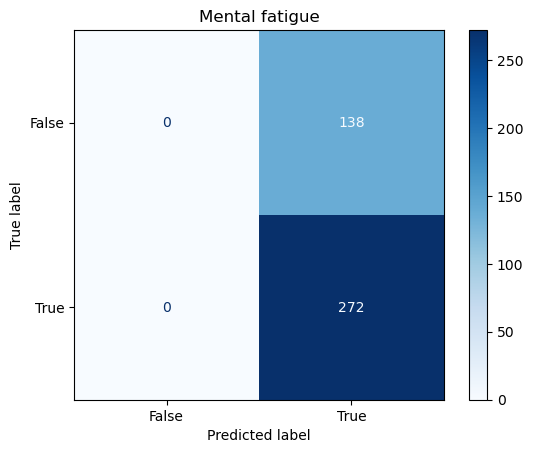

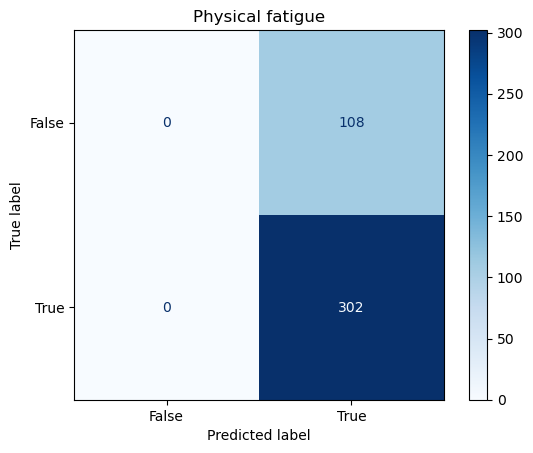

In [134]:
for X, Y in [(X_MF, Y_pred_MF), (X_phF, Y_pred_phF)]:
    confusion_matrix = metrics.confusion_matrix(X, Y)
    metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True]).plot(cmap=plt.cm.Blues)
    plt.title(['Mental fatigue', 'Physical fatigue'][X != X_MF])
    plt.show()

In [135]:
for X, Y in [(X_MF, Y_pred_MF), (X_phF, Y_pred_phF)]:
    print(f'{["Mental fatigue", "Physical fatigue"][X != X_MF]}:')

    accuracy = metrics.accuracy_score(X, Y)
    print(f'Accuracy: {accuracy}')

    balanced_accuracy = metrics.balanced_accuracy_score(X, Y)
    print(f'Balanced accuracy: {balanced_accuracy}')

    f1 = metrics.f1_score(X, Y)
    print(f'F1-score: {f1}')

    precision = metrics.precision_score(X, Y)
    print(f'Precision: {precision}')

    recall = metrics.recall_score(X, Y)
    print(f'Recall: {recall}')

    print('\n')

Mental fatigue:
Accuracy: 0.6634146341463415
Balanced accuracy: 0.5
F1-score: 0.7976539589442815
Precision: 0.6634146341463415
Recall: 1.0


Physical fatigue:
Accuracy: 0.7365853658536585
Balanced accuracy: 0.5
F1-score: 0.848314606741573
Precision: 0.7365853658536585
Recall: 1.0


